# Explore the data

https://insights.stackoverflow.com/survey


## Download the data


In [142]:
import urllib.request
import zipfile
import pandas as pd

url = 'https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip'
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, 'r')
file = zip_file_object.open('survey_results_public.csv')

survey_data = pd.read_csv(file)

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

survey_data.tail(3)

,ResponseId,MainBranch,Employment,RemoteWork,CodingActivities,EdLevel,LearnCode,LearnCodeOnline,LearnCodeCoursesCert,YearsCode,YearsCodePro,DevType,OrgSize,PurchaseInfluence,BuyNewTool,Country,Currency,CompTotal,CompFreq,LanguageHaveWorkedWith,LanguageWantToWorkWith,DatabaseHaveWorkedWith,DatabaseWantToWorkWith,PlatformHaveWorkedWith,PlatformWantToWorkWith,WebframeHaveWorkedWith,WebframeWantToWorkWith,MiscTechHaveWorkedWith,MiscTechWantToWorkWith,ToolsTechHaveWorkedWith,ToolsTechWantToWorkWith,NEWCollabToolsHaveWorkedWith,NEWCollabToolsWantToWorkWith,OpSysProfessional use,OpSysPersonal use,VersionControlSystem,VCInteraction,VCHostingPersonal use,VCHostingProfessional use,OfficeStackAsyncHaveWorkedWith,OfficeStackAsyncWantToWorkWith,OfficeStackSyncHaveWorkedWith,OfficeStackSyncWantToWorkWith,Blockchain,NEWSOSites,SOVisitFreq,SOAccount,SOPartFreq,SOComm,Age,Gender,Trans,Sexuality,Ethnicity,Accessibility,MentalHealth,TBranch,ICorPM,WorkExp,Knowledge_1,Knowledge_2,Knowledge_3,Knowledge_4,Knowledge_5,Knowledge_6,Knowledge_7,Frequency_1,Frequency_2,Frequency_3,TimeSearching,TimeAnswering,Onboarding,ProfessionalTech,TrueFalse_1,TrueFalse_2,TrueFalse_3,SurveyLength,SurveyEase,ConvertedCompYearly
73265,73266,"I am not primarily a developer, but I write co...","Employed, full-time","Hybrid (some remote, some in-person)",Hobby;School or academic work,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;Other online resources ...,Technical documentation;Programming Games;Stac...,Udemy;Codecademy;Pluralsight;edX,42,33,"Developer, full-stack;Developer, desktop or en...",20 to 99 employees,I have a great deal of influence,Start a free trial;Ask developers I know/work ...,United States of America,USD\tUnited States dollar,NaN,NaN,HTML/CSS;JavaScript;PHP;Python;SQL,C#;HTML/CSS;JavaScript;PHP;Python;SQL,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,MariaDB;Microsoft SQL Server;MySQL;PostgreSQL;...,Managed Hosting;Microsoft Azure;VMware,Firebase;Linode;Managed Hosting;Microsoft Azur...,ASP.NET;React.js,ASP.NET;ASP.NET Core ;Blazor;Laravel;Next.js;R...,.NET;Pandas;React Native,.NET;Cordova;Ionic;Pandas;React Native;Xamarin,npm,npm;Unreal Engine,Spyder;Visual Studio;Visual Studio Code,Spyder;Visual Studio;Visual Studio Code,Windows,Windows,Git,Code editor;Command-line;Version control hosti...,NaN,NaN,Microsoft Lists,Microsoft Lists,Microsoft Teams;Zoom,Microsoft Teams;Zoom,Very unfavorable,Stack Overflow;Stack Exchange,Multiple times per day,Yes,Less than once per month or monthly,"Yes, somewhat",55-64 years old,Man,No,Straight / Heterosexual,Multiracial,None of the above,None of the above,Yes,Independent contributor,42.00000,Disagree,Neither agree nor disagree,Disagree,Agree,Agree,Agree,Neither agree nor disagree,Never,Never,Never,30-60 minutes a day,60-120 minutes a day,Just right,None of these,No,No,No,Appropriate in length,Easy,NaN
73266,73267,I am a developer by profession,"Employed, full-time","Hybrid (some remote, some in-person)",Hobby,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Books / Physical media;On the job training,NaN,NaN,50,31,"Developer, front-end;Developer, desktop or ent...",10 to 19 employees,I have a great deal of influence,Start a free trial;Visit developer communities...,United Kingdom of Great Britain and Northern I...,GBP\tPound sterling,58500.00000,Yearly,C#;Delphi;VBA,Delphi,Microsoft SQL Server;MongoDB;Oracle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"RAD Studio (Delphi, C++ Builder);Visual Studio","RAD Studio (Delphi, C++ Builder);Visual Studio",Windows,Windows,SVN,Dedicated version control GUI application,NaN,NaN,NaN,NaN,Zoom,Zoom,Indifferent,Stack Overflow,Daily or almost daily,Yes,I have never participated in Q&A on Stack Over...,"No, not at all",55-64 years old,Man,No,Straight / Heterosexual,European,None of the above,None of the above,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Appropriate in length,Easy,NaN
73267,73268,"I used to be a developer by profession, b

## Clean the data

In [143]:
# Drop rows with no data
survey_data = survey_data.dropna(subset = ["ConvertedCompYearly"])

# Drop rows with extreme outliers
survey_data = survey_data.drop(survey_data[survey_data['ConvertedCompYearly'] > 400000].index)

# Check if the numbers look reasonable
survey_data[['ConvertedCompYearly']].describe()

,ConvertedCompYearly
count,36260.00000
mean,80720.59956
std,65852.55164
min,1.00000
25%,33888.75000
50%,63986.00000
75%,110000.00000
max,400000.00000


## Clean more columns

In [171]:
numeric_features = ['YearsCode', 'YearsCodePro']

for col_name in numeric_features:
    survey_data[col_name] = pd.to_numeric(survey_data[col_name], errors='coerce')
    survey_data = survey_data.dropna(subset = [col_name])  

survey_data[numeric_features].describe()

,YearsCode,YearsCodePro
count,34673.00000,34673.00000
mean,14.65532,9.85032
std,9.39261,8.06228
min,1.00000,1.00000
25%,8.00000,4.00000
50%,12.00000,7.00000
75%,20.00000,14.00000
max,50.00000,50.00000


## Map a column to numbers

In [209]:
survey_data['EdLevelNumeric'] = survey_data['EdLevel'].map({
    'Professional degree (JD, MD, etc.)': 24,
    'Other doctoral degree (Ph.D., Ed.D., etc.)': 22,
    'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)': 18,
    'Bachelor’s degree (B.A., B.S., B.Eng., etc.)': 16,
    'Associate degree (A.A., A.S., etc.)': 14,
    'Some college/university study without earning a degree': 13,
    'Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)': 12,
    'Primary/elementary school': 6,
    'Something else': 0,
})
survey_data = survey_data.dropna(subset = ["EdLevelNumeric"])
numeric_features.append('EdLevelNumeric')
survey_data[["EdLevelNumeric"]].describe()

,EdLevelNumeric
count,34673.00000
mean,16.07386
std,2.86262
min,0.00000
25%,16.00000
50%,16.00000
75%,18.00000
max,24.00000


## Visualize the label column

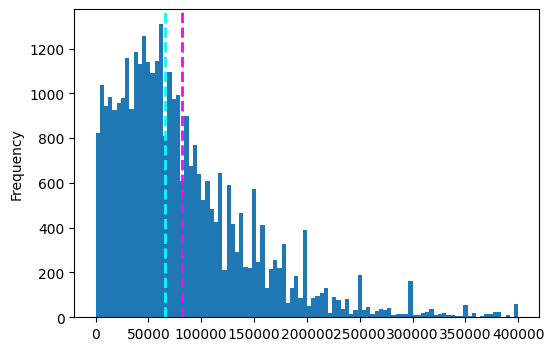

In [146]:
import matplotlib.pyplot as plt

label = survey_data['ConvertedCompYearly']
fig = plt.figure(figsize=(6, 4))
ax = fig.gca()
ax.hist(label, bins=100)
ax.set_ylabel('Frequency')
ax.axvline(label.mean(), color='magenta', linestyle='dashed', linewidth=2)
ax.axvline(label.median(), color='cyan', linestyle='dashed', linewidth=2)

## Visualize the feature columns

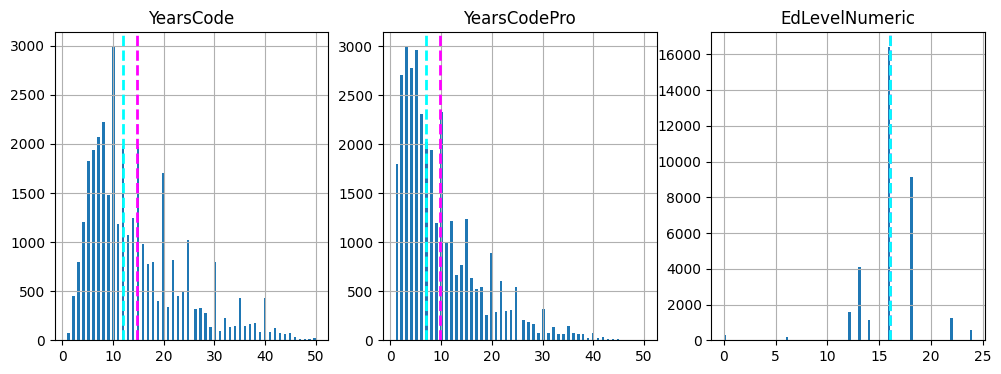

In [210]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ind, col_name in enumerate(numeric_features):
    feature = survey_data[col_name]
    axis = axes[ind]
    feature.hist(bins=100, ax = axis)
    axis.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    axis.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    axis.set_title(col_name)

## Categorical features

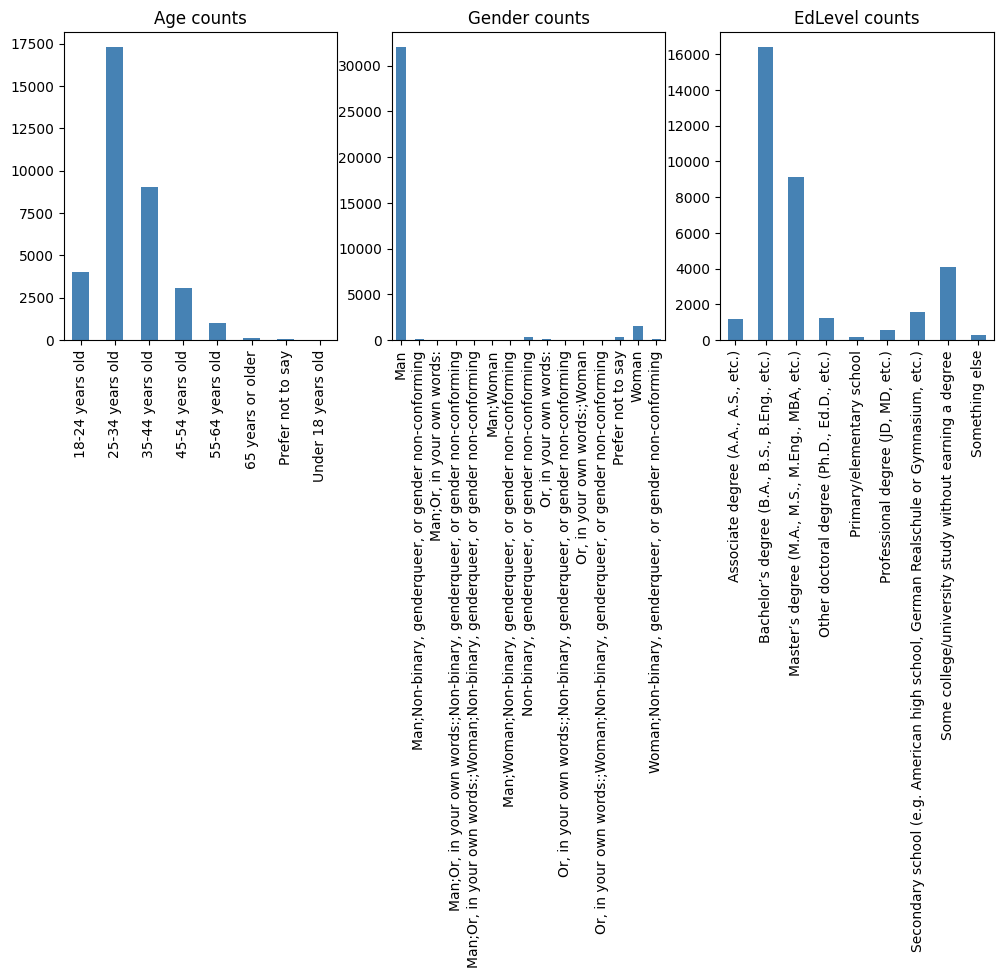

In [211]:
categorical_features = ['Age','Gender', 'EdLevel']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

for ind, col_name in enumerate(categorical_features):
    counts = survey_data[col_name].value_counts().sort_index()
    axis = axes[ind]
    counts.plot.bar(ax=axis, color='steelblue')
    axis.set_title(col_name + ' counts')

## Measure correlations

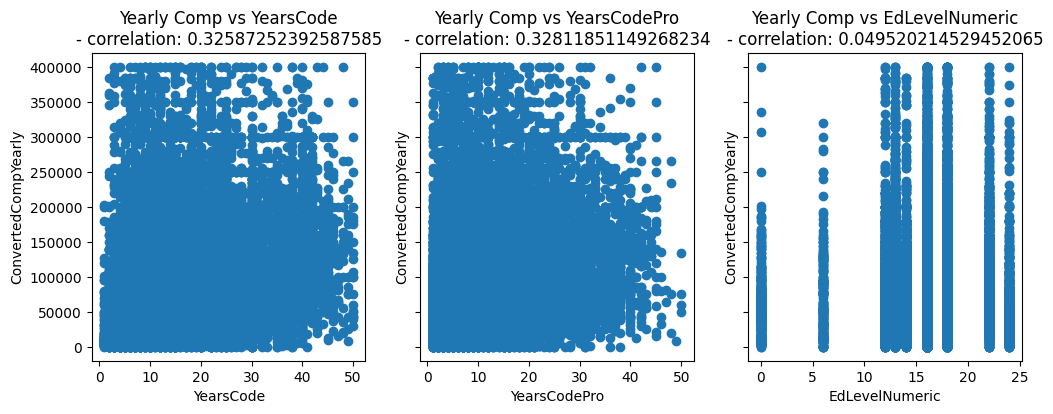

In [213]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4), sharey=True)

for ind, col_name in enumerate(numeric_features):
    feature = survey_data[col_name]
    axis = axes[ind]
    label = survey_data['ConvertedCompYearly']
    correlation = feature.corr(label)
    axis.scatter(x=feature, y=label)
    axis.set_xlabel(col_name)
    axis.set_ylabel('ConvertedCompYearly')
    axis.set_title('Yearly Comp vs ' + col_name + '\n- correlation: ' + str(correlation))


# Build a model

## Separate test and train data

In [150]:
# Separate features and labels
X, y = survey_data[['YearsCode','YearsCodePro', 'EdLevelNumeric']].values, survey_data['ConvertedCompYearly'].values
print('Features:', X[:10], '\nLabels:', y[:10], sep='\n')

Features:
[[14.  5. 18.]
 [20. 17. 16.]
 [ 6.  6. 18.]
 [ 5.  2. 16.]
 [12. 10. 16.]
 [12.  5. 16.]
 [11.  5. 18.]
 [ 7.  4. 16.]
 [13. 10. 18.]
 [36. 22. 12.]]

Labels:
[ 40205. 215232.  49056.  60307. 194400.  65000. 110000.  19224. 202623.
  51192.]


In [151]:
from sklearn.model_selection import train_test_split
# TODO: scikit learn just got a pandas integration, so its easy to pass dfs back and forth

# Split data 70%-30% into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 24271 rows
Test Set: 10402 rows


## Train the model

In [152]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(X_train, y_train)
print(model)

LinearRegression()


## Evaluate model on test data

In [153]:
import numpy as np

predictions = model.predict(X_test)
np.set_printoptions(suppress=True)
print('Predicted labels: ', np.round(predictions)[:10])
print('Actual labels   : ', y_test[:10])

Predicted labels:  [151444.  77213.  59412.  76888.  62289.  89243.  82092.  67452.  73102.
  62202.]
Actual labels   :  [175000.  14448. 120000. 108590.  96300.  68832. 131181.  91883. 118374.
  38388.]


## Visualize the predictions

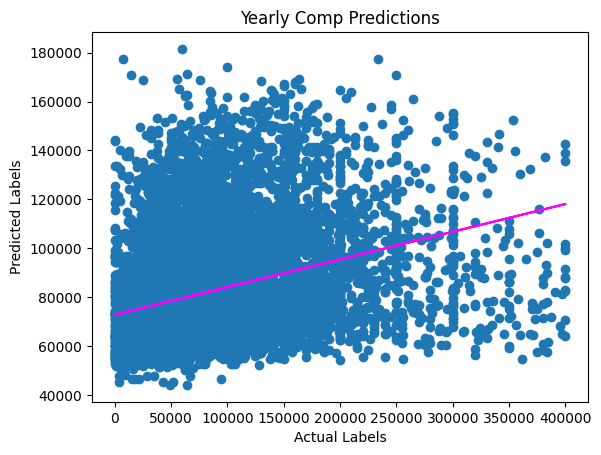

In [154]:
plt.scatter(y_test, predictions)
plt.xlabel('Actual Labels')
plt.ylabel('Predicted Labels')
plt.title('Yearly Comp Predictions')
# Overlay the regression line
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='magenta')

## Calculate evaluation metrics

In [155]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, predictions)
print("MSE:", mse)

rmse = np.sqrt(mse)
print("RMSE:", rmse)

r2 = r2_score(y_test, predictions)
print("R2:", r2) # TODO: be able to explain better. residuals squared. higher is better.

MSE: 3860676140.426591
RMSE: 62134.33946238256
R2: 0.1146969181801819


# Experiment with more models

* **Linear algorithms**: Not just the Linear Regression algorithm we used above (which is technically an Ordinary Least Squares algorithm), but other variants such as Lasso and Ridge.
* **Tree-based algorithms**: Algorithms that build a decision tree to reach a prediction.
* **Ensemble algorithms**: Algorithms that combine the outputs of multiple base algorithms to improve generalizability.

https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html

## Generalize the evaluation process

In [156]:
def evaluate_model():
    # Evaluate the model using the test data
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, predictions)
    print("MSE:", mse, " RMSE:", rmse, " R2:", r2, )

    # Plot predicted vs actual
    plt.scatter(y_test, predictions)
    plt.xlabel('Actual Labels')
    plt.ylabel('Predicted Labels')
    plt.title('Yearly Comp Predictions')
    # Overlay the regression line
    z = np.polyfit(y_test, predictions, 1)
    p = np.poly1d(z)
    plt.plot(y_test,p(y_test), color='magenta')

## Lasso (linear regression)

Lasso works well when only a few features predict the label.

https://scikit-learn.org/stable/modules/linear_model.html#lasso

MSE: 3860677347.752502  RMSE: 62134.34917782999  R2: 0.11469664132470092


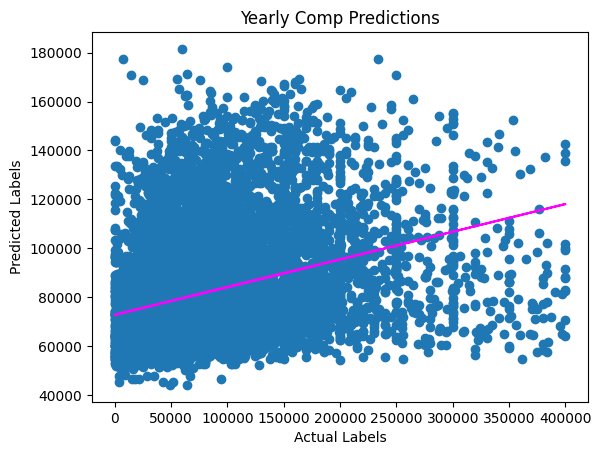

In [157]:
from sklearn.linear_model import Lasso

# Fit a lasso model on the training set
model = Lasso().fit(X_train, y_train)

evaluate_model()

## Decision tree

Decision trees can be used for both regression and classification problems.

https://scikit-learn.org/stable/modules/tree.html#

In [158]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text

model = DecisionTreeRegressor().fit(X_train, y_train)

# Visualize the model tree
tree = export_text(model)
print(tree)
# TODO: graphviz trees: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

|--- feature_1 <= 5.50
|   |--- feature_1 <= 3.50
|   |   |--- feature_0 <= 5.50
|   |   |   |--- feature_1 <= 2.50
|   |   |   |   |--- feature_2 <= 17.00
|   |   |   |   |   |--- feature_1 <= 1.50
|   |   |   |   |   |   |--- feature_0 <= 4.50
|   |   |   |   |   |   |   |--- feature_2 <= 15.00
|   |   |   |   |   |   |   |   |--- feature_0 <= 3.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 2.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 12.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 4
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  12.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- feature_0 >  2.50
|   |   |   |   |   |   |   |   |   |   |--- feature_2 <= 12.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_2 >  12.50
|   |   |   |   |   |   |   |   |   |   | 

## Decision tree (evaluation)

MSE: 4370694271.3100815  RMSE: 66111.22651494284  R2: -0.0022568501836275345


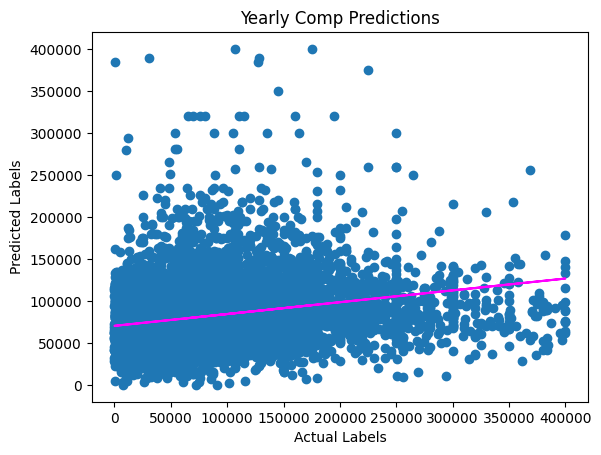

In [159]:
evaluate_model()

## Random forest (ensemble)

Applies an averaging function to multiple Decision Tree models for a better overall model
https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees

MSE: 4069995510.023426  RMSE: 63796.516441130436  R2: 0.0666972734940613


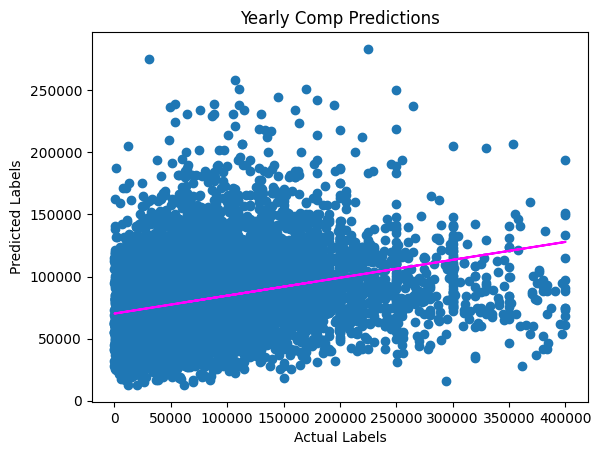

In [160]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor().fit(X_train, y_train)

evaluate_model() # TODO: Add to a pandas dataframe to show our progress so far

## Gradient tree boosting

https://scikit-learn.org/stable/modules/ensemble.html#gradient-tree-boosting

MSE: 3751919086.9726954  RMSE: 61252.91084489533  R2: 0.13963632026681683


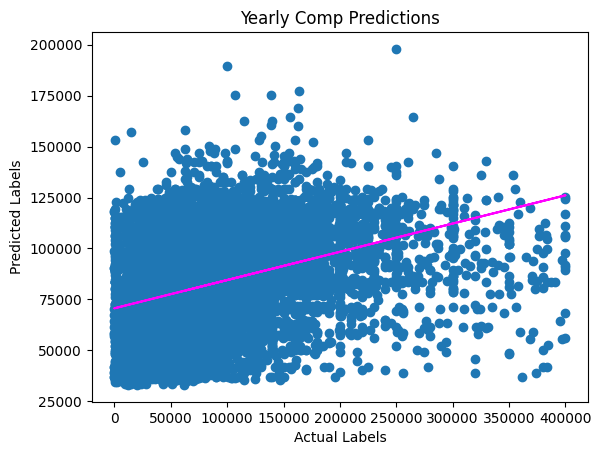

In [161]:
from sklearn.ensemble import GradientBoostingRegressor

model = GradientBoostingRegressor().fit(X_train, y_train)

evaluate_model()

## Improve model

* Tune hyperparameters
* Preprocess data

https://learn.microsoft.com/en-us/training/modules/train-evaluate-regression-models/6-improve-models
    

## Tune hyperparameters

In [162]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, r2_score

# Use a Gradient Boosting algorithm
alg = GradientBoostingRegressor()

# Try these hyperparameter values
params = {
 'learning_rate': [0.1, 0.5, 1.0],
 'n_estimators' : [50, 100, 150]
 }

# Find the best hyperparameter combination to optimize the R2 metric
score = make_scorer(r2_score)
gridsearch = GridSearchCV(alg, params, scoring=score, cv=3, return_train_score=True)
gridsearch.fit(X_train, y_train)
print("Best parameter combination:", gridsearch.best_params_, "\n")

# Get the best model
model = gridsearch.best_estimator_ # TODO but why
print(model, "\n")

Best parameter combination: {'learning_rate': 0.1, 'n_estimators': 50} 

GradientBoostingRegressor(n_estimators=50) 



## Evaluate tuned model

MSE: 3747947501.4799566  RMSE: 61220.482695581195  R2: 0.14054705630074993


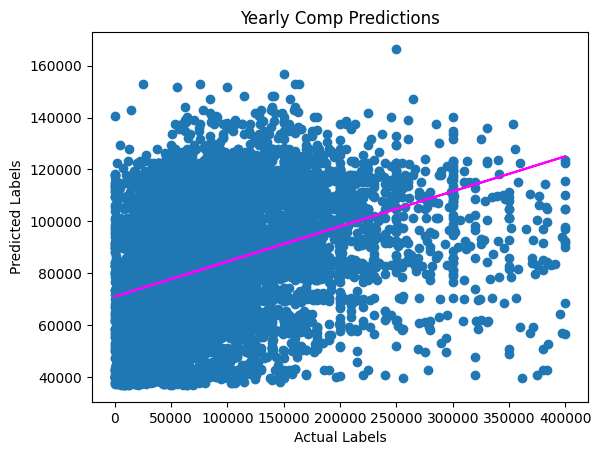

In [163]:
evaluate_model()

## Pre-processing pipeline

In [164]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Separate features and labels
X, y = survey_data[['YearsCode','YearsCodePro', 'EdLevel', 'MainBranch', 'Country']].values, survey_data['ConvertedCompYearly'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Define preprocessing for numeric columns (scale them)
numeric_features = [0, 1]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# Define preprocessing for categorical features (encode them)
categorical_features = [2, 3, 4]
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', model)])

# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))

## Evaluate tuned model

MSE: 2373811604.3850784  RMSE: 48721.777516682196  R2: 0.4556542293160224


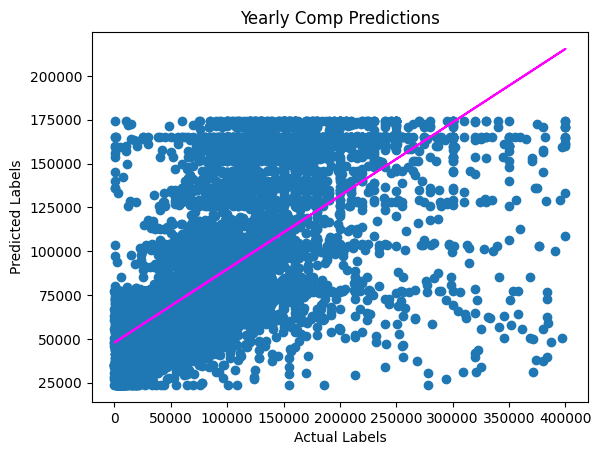

In [165]:
evaluate_model() # TODO: why the cap

## Store the model

In [166]:
import joblib

# Save the model as a pickle file
filename = './function/yearly-comp.pkl'
joblib.dump(model, filename)

# TODO hdf5 - compression format - what is most performant for pickling/depickling?
# cafe and tf files are other types of model files
# or pickle? onyx
# TODO: read scikit learn's page

['./function/yearly-comp.pkl']

## Use the stored model

In [167]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array([[25, 15, 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)','I am a developer by profession', ' ']])
#X_new = np.array([[8, 6, 'Bachelor’s degree (B.A., B.S., B.Eng., etc.)','I am a developer by profession', 'United States of America']])
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
result = loaded_model.predict(X_new)
print('Prediction: ${:.0f}'.format(np.round(result[0])))

New sample: ['25', '15', 'Master’s degree (M.A., M.S., M.Eng., MBA, etc.)', 'I am a developer by profession', ' ']
Prediction: $76953


In [168]:
uniques = []
for country in survey_data['Country'].unique():
    var_name = country.replace(' ', '_').upper() # todo: slugify
    #print(var_name + ' = "' + country + '"')

survey_data['MainBranch'].unique()
# TODO: generate enums.py and save it

array(['I am not primarily a developer, but I write code sometimes as part of my work',
       'I am a developer by profession'], dtype=object)